<a href="https://colab.research.google.com/github/AnnaVitali/plantRecognition/blob/develop/plantDiseasesRecognition_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Riconoscimento delle malattie delle piante

Il problema che si vuole andare a risolvere consiste nel riconoscere le diverse malattie, che possono affligere una certa tipologia di pianta, a partire da un'immagine della foglia.

# Download training set

url del dataset di riferimento: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset 

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset

Saving kaggle.json to kaggle.json
ref                                                              title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ahsan81/hotel-reservations-classification-dataset                Hotel Reservations Dataset                          480KB  2023-01-04 12:50:31           8085        281  1.0              
googleai/musiccaps                                               MusicCaps                                           793KB  2023-01-25 09:25:48           1364        144  0.9411765        
themrityunjaypathak/most-subscribed-1000-youtube-channels        Most Subscribed 1000 Youtube Channels                28KB  2023-01-21 14:42:05           1825         58  1.0              
senapatirajesh/netfli

In [ ]:
! unzip new-plant-diseases-dataset.zip

# Import

In [ ]:
import os
import glob
import re
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import random
import shutil
from PIL import Image
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from ipywidgets import interact, fixed
import ipywidgets as widgets
import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16
from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import img_to_array
from keras.layers.reshaping.flatten import Flatten
from keras.models import Model
from keras.layers import Dense
from sklearn import metrics

from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
%tensorflow_version 2.x

!pip uninstall -y h5py
!pip install h5py==2.10.0

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found existing installation: h5py 3.1.0
Uninstalling h5py-3.1.0:
  Successfully uninstalled h5py-3.1.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 73.2 MB/s eta 0:00:00


# Caricamento dataset

Il dateset contiene in tutto 87K immagini RGB di foglie con malattie e sane riferite, a 14 diverse tipologie di piante:

- in totale sono presenti 38 classi;
- è diviso secondo un rapporto 70/30 in dati del training set e dati del test set;
- le diverse immagini sono ragruppate in cartelle per le classi corrispondenti.

In [ ]:
db_path_train = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
db_path_valid = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'

In [ ]:
train = tf.keras.utils.image_dataset_from_directory(
    db_path_train,
    labels="inferred",
    seed=1337,
    image_size=(224, 224)
)

valid = tf.keras.utils.image_dataset_from_directory(
    db_path_valid,
    validation_split = 0.3,
    subset="training",
    labels="inferred",
    seed=1337,
    image_size=(224, 224)
)

test = tf.keras.utils.image_dataset_from_directory(
    db_path_valid,
    validation_split = 0.3,
    subset="validation",
    labels="inferred",
    seed=1337,
    image_size=(224, 224)
)


Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.
Using 12301 files for training.
Found 17572 files belonging to 38 classes.
Using 5271 files for validation.


In [ ]:
class_names = train.class_names
print(class_names)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

# Visualizzazione immagini

Le classi del problema sono le seguenti:
- Apple
  - Apple scab, 
  - Black rot, 
  - Cedar apple rust,
  - healthy, 
- Blueberry
  - healthy, 
- Cherry
  - Powdery mildew,
  - healthy,
- Corn
  - Cercospora leaf spot Gray leaf spot,
  - Common rust, 
  - Northern Leaf Blight,
  - healthy,
- Grape
  - Black rot,
  - Esca (Black Measles), 
  - Leaf blight (Isariopsis_Leaf_Spot), 
  - healthy,
- Orange
  - Haunglongbing (Citrus_greening),
- Peach
  - Bacterial spot, 
  - healthy,
- Pepper
  - Bacterial spot,
  - healthy, 
- Potato
  - Early blight,
  - Late blight,
  - healthy, 
- Raspberry
  - healthy,
- Soybean
  - healthy,
- Squash
  - Powdery mildew, 
- Strawberry
  - Leaf_scorch, 
  - healthy,
- Tomato
  - Bacterial spot,
  - Early blight
  - Late blight,
  - Leaf Mold,
  - Septoria leaf spot,
  - Spider mites Two-spotted spider mite, 
  - Target Spot, 
  - Yellow Leaf Curl Virus,
  - mosaic virus,
  - healthy.

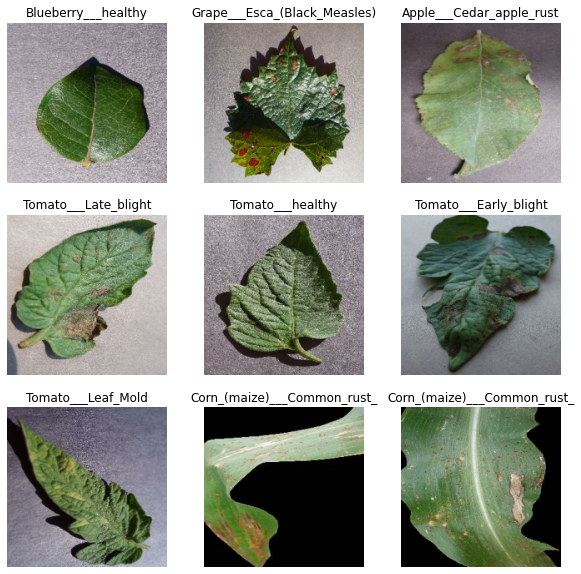

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Definizione del modello

Come modello di partenza si è deciso di utilizzare *MobileNet* addestrata con i pesi di **imagenet**:
- la dimensione delle immagini di input è di 224 x 224 x 3


In [ ]:
# Load the base model
pre_trained_model =  keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)
print(pre_trained_model.summary())

# Stop from being trainable
pre_trained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

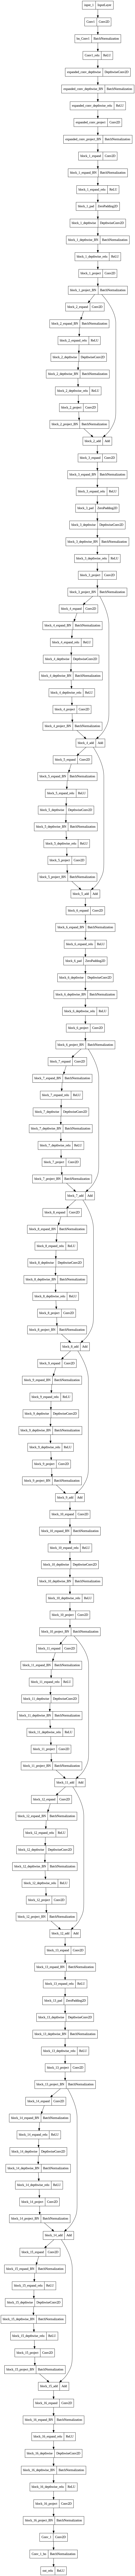

In [ ]:
plot_model(pre_trained_model, to_file='mobileNet.png')

## Fine tuning 

A partire dal modello MobileNet preaddestrato, è stato definito un nuovo modello in questo modo:
- aggiungendo un nuovo livello *Fully Connected*, al modello preaddestrato, adattando il numero di classi con quelle del nostro problema;
- come funzione di attivazione di questo livello è stato utilizzata *soft_max*.

Per l'addestramento del modello è stato utilizzato come ottimizzatore *adam* e come funzione di loss *sparse_categorical_crossentropy*.


In [ ]:
model = keras.models.Sequential()
model.add(pre_trained_model)
model.add(Flatten())
model.add(Dense(len(class_names), activation='softmax'))

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer = "adam",
    metrics = ["accuracy"]
)

print('Inputs: %s' % model.inputs)
print('Outputs: %s' % model.outputs)

model.summary()

Inputs: [<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'mobilenetv2_1.00_224_input')>]
Outputs: [<KerasTensor: shape=(None, 38) dtype=float32 (created by layer 'dense_4')>]
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_4 (Flatten)         (None, 62720)             0         
                                                                 
 dense_4 (Dense)             (None, 38)                2383398   
                                                                 
Total params: 4,641,382
Trainable params: 2,383,398
Non-trainable params: 2,257,984
_________________________________________________________________


## Addestramento del modello

Per l'addestramento del modello sono state utilizzate 3 epoche, in quanto si è visto che aumentando questo numero, anche se l'accuratezza migliora, la **loss** invece peggiora.

In [ ]:
history = model.fit(train, validation_data = valid, epochs = 3)

Epoch 1/3
2197/2197 [==============================] - 135s 60ms/step - loss: 4.5065 - accuracy: 0.7189 - val_loss: 3.6151 - val_accuracy: 0.7996
Epoch 2/3
2197/2197 [==============================] - 130s 59ms/step - loss: 2.7381 - accuracy: 0.8524 - val_loss: 4.7582 - val_accuracy: 0.8029
Epoch 3/3
2197/2197 [==============================] - 131s 60ms/step - loss: 2.2044 - accuracy: 0.8876 - val_loss: 4.1122 - val_accuracy: 0.8407


In [ ]:
#Saving our model
filepath="model.h5"
model.save(filepath)

## Visualizzazione grafici accuratezza e loss

Come si può vedere dalle immagini, l'accuratezza:
- sul *training set* aumenta notevolmente fin dalla prima epoca, per poi rallentare dalla terza epoca in poi;
- sul *validation set* invece, fino alla seconda epoca rimane stabile e poi aumenta.

Per quanto riguarda la *loss*:
- per il *training set* tende a diminuire man mano che le epoche aumentano;
- per il *validation set*, la loss aumenta durante la prima epoca per poi diminuire nella seconda.


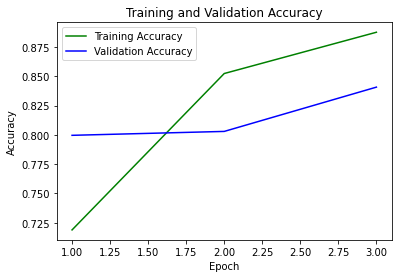

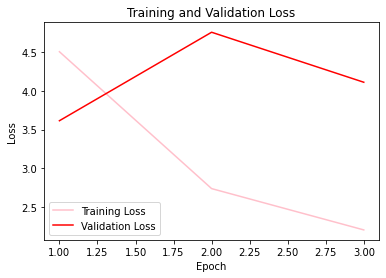

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()

#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Predizioni sul test set

A questo punto è possibile sottomettere alla rete il *test set* e valutare le prestazioni ottenute:
- l'accuratezza ottenuta è del 87%;
- la classe in cui sono stati ottenuti i risultati peggiori è stata la Tomato___Septoria_leaf_spot con una precisione di 45%;
  - questo può essere dovuto al fatto che per la classe Tomato si hanno diverse tipologie di malattie;
- le classi in cui sono stati ottenuti i risultati migliori sono Orange___Haunglongbing_(Citrus_greening) e Corn_(maize)___healthy con una precisione di 100%;
  - probabilmente perchè le foglie di queste tipologie di piante e le malattie rilevate risultano essere facilmente distinguibili dalle altre.

In [ ]:
predictions = np.array([])
labels =  np.array([])
for x, y in tqdm(test):
  pred =  model.predict(x, verbose=False).argmax(axis=-1)
  predictions = np.concatenate([predictions,pred])
  labels = np.concatenate([labels, y])

  0%|          | 0/165 [00:00<?, ?it/s]

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.64      0.85      0.73       154
                                 Apple___Black_rot       0.81      0.92      0.86       160
                          Apple___Cedar_apple_rust       0.90      0.95      0.92       153
                                   Apple___healthy       0.61      0.92      0.73       133
                               Blueberry___healthy       0.93      0.82      0.87       123
          Cherry_(including_sour)___Powdery_mildew       0.96      0.88      0.92       137
                 Cherry_(including_sour)___healthy       0.99      0.91      0.95       141
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.95      0.63      0.76       114
                       Corn_(maize)___Common_rust_       0.99      0.99      0.99       151
               Corn_(maize)___Northern_Leaf_Blight       0.86      0.79      0.

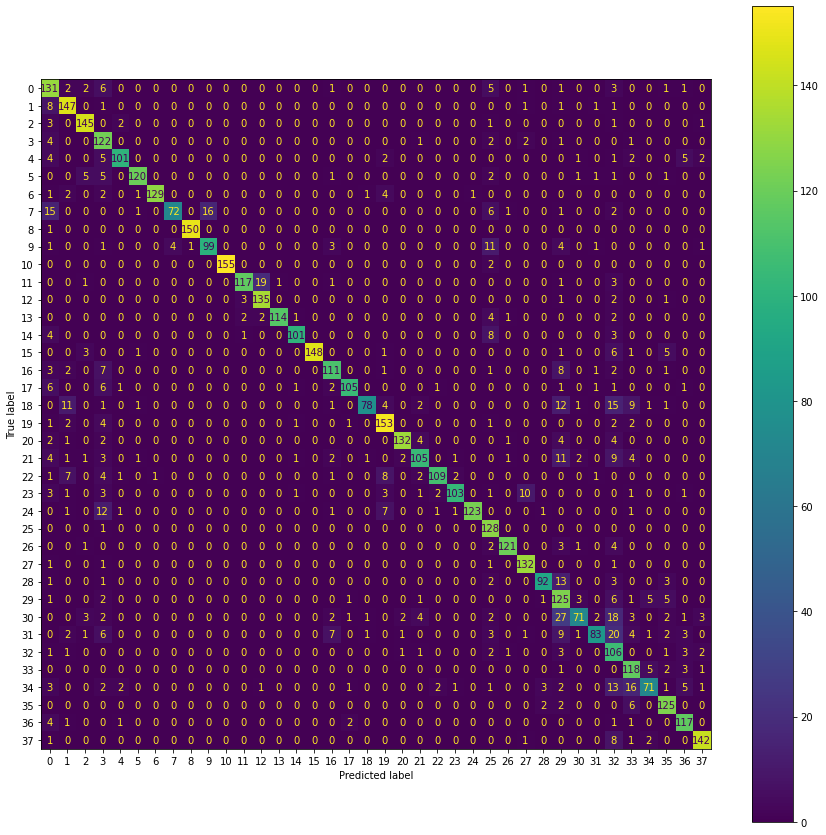

In [ ]:
print(classification_report(labels, predictions, target_names=class_names))

matrix = confusion_matrix(labels, predictions)
diagonal = matrix.diagonal()/matrix.sum(axis=1)

# Mostriamo la matrice di confusione
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(len(class_names))))
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax)

# Conclusioni

Complessivamente i risultati ottenuti sono abbastanza buoni. 
Problematiche della soluzione adottata:
- la *loss* sul validation set non ha un andamento stabile;
- necessario diverso tempo per effettuare le differenti epoche;
- se si diminuisce le dimensioni delle immagini, le prestazioni calano di molto.

Possibili modifiche e miglioramenti:
- aumentare la dimensione dell'immagine;
- aggiungere ulteriori livelli al modello, cercando di ridurre l'*overfitting*, ad esempio adottando il Drop-out o ulteriori livelli di Pooling;
- adottare un'altra funzione per misurare la *loss*;
- modificare l'ottimizzatore;
- aumentare le epoche.
